# <center> Summer Load </center> 

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [2]:
LABELS = ['so2_kg', 'nox_kg', 'pm25_kg', 'co2_kg', 'so2_dam_ap2', 'nox_dam_ap2',
       'pm25_dam_ap2', 'so2_dam_eas', 'nox_dam_eas', 'pm25_dam_eas',
       'co2_dam', 'dam_ap2', 'dam_eas']
LABELS.sort()
dam_cols_ap2 = ['co2_dam', 'so2_dam_ap2', 'nox_dam_ap2', 'pm25_dam_ap2']
dam_cols_eas = ['co2_dam', 'so2_dam_eas', 'nox_dam_eas', 'pm25_dam_eas']

In [3]:
GROUPING_NAMES = ['SeasonalTOD', 'MonthTOD', 'TOD', 'YearOnly', 'Month', 'Hour']
GROUPING_COLS = [['year', 'season', 'hour'], ['year', 'month', 'hour'], 
        ['year', 'hour'], ['year'], ['year', 'month'], ['DATE_UTC']]
GROUPING_NAMES_COLS = dict(zip(GROUPING_NAMES, GROUPING_COLS))

## Read in data 

In [4]:
def get_factor_df(kind='MEF', time='MonthTOD', region='PJM', fuel_type='FossilOnly'):
    kind_folder = 'mefs' if kind=='MEF' else 'aefs'
    
    # Read in file
    if fuel_type == 'FossilOnly':
        region_breakdown = 'isorto' if region == 'PJM' else 'nerc'
        df = pd.read_csv(os.path.join(os.pardir, os.pardir, 'factor_estimates', 'calculated_factors', 
                                      kind_folder, time, 
                                      '{}_{}.csv'.format(region_breakdown, kind_folder)),
                         index_col=GROUPING_NAMES_COLS[time])
        df = df[df[region_breakdown] == region].drop(region_breakdown, axis=1)
    else:
        if region != 'PJM':
            raise NotImplementedError('fossil-plus factors are only available for PJM')
        df = pd.read_csv(os.path.join(os.pardir, os.pardir, 'factor_estimates', 'calculated_factors', 
                                      kind_folder, time, 
                                      'pjm_fplus_{}.csv'.format(kind_folder)),
                         index_col=GROUPING_NAMES_COLS[time])
        
    # Filter MEF columns
    if kind == 'MEF':
        df = df.drop([x for x in df.columns if '-r' in x or '-int' in x], axis=1)
        df.columns = [x.replace('-est', '') for x in df.columns]
        
    # Ensure columns have numeric type
    df = df.apply(pd.to_numeric, axis=1)
    
    return df

In [5]:
all_dfs = {}
for kind in ['MEF', 'AEF']:
    for region in ['PJM', 'RFC']:
        for fuel_type in ['FossilOnly', 'FossilPlus']:
            for time in ['YearOnly', 'Month', 'MonthTOD', 'Hour']:
                if region == 'RFC' and fuel_type == 'FossilPlus': 
                    continue
                if kind == 'MEF' and time == 'Hour':
                    continue
                print(kind, region, fuel_type, time)
                df = get_factor_df(kind=kind, time=time, region=region, fuel_type=fuel_type)
                all_dfs[(kind, region, fuel_type, time)] = df

MEF PJM FossilOnly YearOnly
MEF PJM FossilOnly Month
MEF PJM FossilOnly MonthTOD
MEF PJM FossilPlus YearOnly
MEF PJM FossilPlus Month
MEF PJM FossilPlus MonthTOD
MEF RFC FossilOnly YearOnly
MEF RFC FossilOnly Month
MEF RFC FossilOnly MonthTOD
AEF PJM FossilOnly YearOnly
AEF PJM FossilOnly Month
AEF PJM FossilOnly MonthTOD
AEF PJM FossilOnly Hour
AEF PJM FossilPlus YearOnly
AEF PJM FossilPlus Month
AEF PJM FossilPlus MonthTOD
AEF PJM FossilPlus Hour
AEF RFC FossilOnly YearOnly
AEF RFC FossilOnly Month
AEF RFC FossilOnly MonthTOD
AEF RFC FossilOnly Hour


## Get summer load

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
metered_loads = pd.DataFrame(pd.read_csv(
        os.path.join(os.pardir, os.pardir, 'data', 'metered_loads', 'formatted_data', 'hourly_loads.csv'),
        index_col=0, parse_dates=[0]))['RTO-HrMeteredLoad']
metered_loads = pd.DataFrame(metered_loads.loc['2017-01-01':'2017-12-31'])

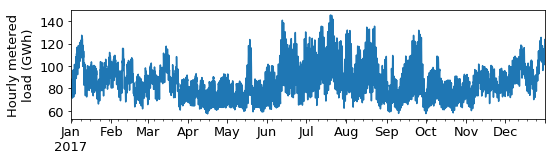

In [8]:
fontsize=13
fig, ax = plt.subplots(figsize=(8.5, 2))
(metered_loads/1e3).plot(legend=False, ax=ax, fontsize=fontsize);
ax.set_ylabel('Hourly metered\nload (GWh)', fontsize=fontsize);
ax.set_xlabel('');
# if not os.path.exists(os.path.join('figures', 'summer_load')):
#     os.makedirs(os.path.join('figures', 'summer_load'))
# fig.savefig(os.path.join('figures', 'summer_load', 'load_profile.pdf'), bbox_inches='tight')

In [9]:
print('Peak load: {}'.format((metered_loads/1e3).max()[0]))
print('Peak load summer: {}'.format(((metered_loads/1e3).loc['2017-06-01':'2017-08-31']).max()[0]))
print('Peak load non summer: {}'.format(
    pd.concat([(metered_loads/1e3).loc[:'2017-05-31'], (metered_loads/1e3).loc['2017-09-01':]]).max()[0]))

Peak load: 145.637464
Peak load summer: 145.637464
Peak load non summer: 131.99821400000002


In [10]:
# Measure load only in summer
hours_summer = pd.date_range('2017-06-01', '2017-09-01', freq='H', closed='left')
intervention_df = pd.DataFrame(metered_loads.loc[hours_summer])

## Get intervention effects

In [11]:
def get_hour_factors(df, time, hours, prev_year=False):
    year_series = hours.map(lambda x: x.year-1) if prev_year else hours.map(lambda x: x.year)
    month_series = hours.map(lambda x: x.month)
    hour_series = hours.map(lambda x: x.hour)
    every_hour_series = hours.map(lambda x: x.replace(year=x.year-1)) if prev_year else hours
    if time == 'YearOnly':
        df2 = df.loc[year_series]
    elif time == 'Month':
        df2 = df.loc[list(zip(year_series, month_series))]
    elif time == 'MonthTOD':
        df2 = df.loc[list(zip(year_series, month_series, hour_series))]
    elif time == 'Hour':
#         df2 = df.loc[year_series]
        df2 = df.loc[every_hour_series.map(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))]
    df2 = df2.set_index(hours)
    return df2

In [12]:
# Get factor for each point in time series
hours_summer_factors = {}
for key in all_dfs.keys():
#     print(key)
    df = all_dfs[key]
    
    # 2017
    df2 = get_hour_factors(df, key[-1], hours_summer)
    hours_summer_factors[key + (2017,)] = df2
    
    # 2016 for PJM fossil-only (but not for hourly)
    if key[1] == 'PJM' and key[2] == 'FossilPlus' and key[-1] != 'Hour':
        df3 = get_hour_factors(df, key[-1], hours_summer, True)
        hours_summer_factors[key + (2016,)] = df3

In [13]:
# Calculate effects
intervention_effects = {}
for key in hours_summer_factors.keys():
    reds = hours_summer_factors[key].multiply(intervention_df['RTO-HrMeteredLoad'], axis='index')
    effects = reds[LABELS].sum()  # total effect
    
    # For MEFs, propagate error. 
    #   When same factor is applied to multiple reductions 
    #      (i.e. multiplied by their total reduction amount), this factor's SE should be summed across
    #      these reductions (i.e. also multiplied by the total reduction amount).
    #   Independent errors (from different factors) should then be combined by the sqrt of their
    #      sum of squares.
    if key[0] == 'MEF':
        
        # Per-factor (non-independent) errors
        groupby_list = dict([('YearOnly', reds.index.year), 
                             ('Month', [reds.index.year, reds.index.month]),
                             ('MonthTOD', [reds.index.year, reds.index.month, reds.index.hour]),
                             ('Hour', [reds.index])])
        per_factor_errors = reds[['{}-se'.format(x) for x in LABELS]].groupby(
            groupby_list[key[-2]]).sum()
        
        # Combine per-factor errors to get independent errors
        ses = np.sqrt((per_factor_errors ** 2).sum())
#         ses = np.sqrt((reds[['{}-se'.format(x) for x in LABELS]] ** 2).sum())

        effects = pd.concat([effects, ses])
    intervention_effects[key] = effects

In [14]:
intervention_effects_df = pd.DataFrame(intervention_effects).T
intervention_effects_df.index.names = ['kind', 'region', 'fuel_type', 'time', 'year']

## Some analysis 

In [15]:
def get_summary(intervention_effects_df, pollutant):
    poll_effect = intervention_effects_df[pollutant]
    print('Min: {}, {}'.format(poll_effect.min(), poll_effect.idxmin()))
    print('Max: {}, {}'.format(poll_effect.max(), poll_effect.idxmax()))
    print(poll_effect.T)
    return poll_effect.T

In [16]:
df = get_summary(intervention_effects_df, 'dam_eas')

Min: 6378012055.467654, ('AEF', 'PJM', 'FossilPlus', 'YearOnly', 2017)
Max: 13189150331.51452, ('MEF', 'PJM', 'FossilPlus', 'YearOnly', 2016)
kind  region  fuel_type   time      year
AEF   PJM     FossilOnly  Hour      2017    1.067032e+10
                          Month     2017    1.068773e+10
                          MonthTOD  2017    1.068324e+10
                          YearOnly  2017    1.092881e+10
              FossilPlus  Hour      2017    6.522816e+09
                          Month     2016    7.800685e+09
                                    2017    6.503181e+09
                          MonthTOD  2016    7.812590e+09
                                    2017    6.519000e+09
                          YearOnly  2016    7.265656e+09
                                    2017    6.378012e+09
      RFC     FossilOnly  Hour      2017    1.229327e+10
                          Month     2017    1.229878e+10
                          MonthTOD  2017    1.229790e+10
                   

In [17]:
baseline = df.loc[('AEF', 'PJM', 'FossilPlus', 'Hour', 2017)]
baseline

6522815747.42828

In [18]:
(100 * df/baseline).round(0).astype(int)

kind  region  fuel_type   time      year
AEF   PJM     FossilOnly  Hour      2017    164
                          Month     2017    164
                          MonthTOD  2017    164
                          YearOnly  2017    168
              FossilPlus  Hour      2017    100
                          Month     2016    120
                                    2017    100
                          MonthTOD  2016    120
                                    2017    100
                          YearOnly  2016    111
                                    2017     98
      RFC     FossilOnly  Hour      2017    188
                          Month     2017    189
                          MonthTOD  2017    189
                          YearOnly  2017    192
MEF   PJM     FossilOnly  Month     2017    178
                          MonthTOD  2017    171
                          YearOnly  2017    173
              FossilPlus  Month     2016    199
                                    2017    177

In [19]:
df = get_summary(intervention_effects_df, 'dam_ap2')

Min: 7028145583.336672, ('AEF', 'PJM', 'FossilPlus', 'YearOnly', 2017)
Max: 16011547627.906507, ('MEF', 'PJM', 'FossilPlus', 'YearOnly', 2016)
kind  region  fuel_type   time      year
AEF   PJM     FossilOnly  Hour      2017    1.165696e+10
                          Month     2017    1.168750e+10
                          MonthTOD  2017    1.167906e+10
                          YearOnly  2017    1.204282e+10
              FossilPlus  Hour      2017    7.136303e+09
                          Month     2016    8.918834e+09
                                    2017    7.111130e+09
                          MonthTOD  2016    8.934776e+09
                                    2017    7.131407e+09
                          YearOnly  2016    8.335493e+09
                                    2017    7.028146e+09
      RFC     FossilOnly  Hour      2017    1.291551e+10
                          Month     2017    1.293276e+10
                          MonthTOD  2017    1.292856e+10
                  

In [20]:
baseline = df.loc[('AEF', 'PJM', 'FossilPlus', 'Hour', 2017)]
baseline

7136302558.828144

In [21]:
(100 * df/baseline).round(0).astype(int)

kind  region  fuel_type   time      year
AEF   PJM     FossilOnly  Hour      2017    163
                          Month     2017    164
                          MonthTOD  2017    164
                          YearOnly  2017    169
              FossilPlus  Hour      2017    100
                          Month     2016    125
                                    2017    100
                          MonthTOD  2016    125
                                    2017    100
                          YearOnly  2016    117
                                    2017     98
      RFC     FossilOnly  Hour      2017    181
                          Month     2017    181
                          MonthTOD  2017    181
                          YearOnly  2017    186
MEF   PJM     FossilOnly  Month     2017    189
                          MonthTOD  2017    185
                          YearOnly  2017    183
              FossilPlus  Month     2016    219
                                    2017    189

## Bar plots for SI

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
def get_dam_name(dam_abbr):
    return 'AP2' if dam_abbr == 'ap2' else 'EASIUR'
    
FULL_DAMS = ['dam_ap2', 'dam_eas']
def format_title(label):
    l = label.split('_')
    if label in FULL_DAMS:
        t = 'Total damages ({})'.format('AP2' if l[1] == 'ap2' else 'EASIUR')
    else:
        t = '{0}$_{{{1}}}$ {2}'.format(l[0][:2].upper(), l[0][2:], 'emissions' if l[1] == 'kg' else 'damages')
        if len(l) > 2: t += ' ({})'.format('AP2' if l[2] == 'ap2' else 'EASIUR')
    return t

def format_axis(label):
    l = label.split('_')
    if label in FULL_DAMS:
        t = 'Total damages ($)'
    elif len(l) > 2 or l[1] == 'dam':
        t = 'Damages ($)'
    else:
        t = 'Emissions (kg)'
    return t

In [24]:
# Get formatted df with intervention effects for given label
def get_onelabel_formatted(label):
    kind_map = dict([('MEF', 'Marginal'), ('AEF', 'Average')])
    time_map = dict([('YearOnly', 'Annual'), ('MonthTOD', 'Monthly TOD'), ('Month', 'Monthly'), ('Hour', 'Hourly')])
    
    df = intervention_effects_df[label].reset_index()
    df['spat'] = df.apply(
        lambda x: '{} ({}-{}{})'.format(
            x['region'], x['fuel_type'][:-4].lower(), x['fuel_type'][-4:].lower(), 
            ' 2016' if x['year'] == 2016 else ''), axis=1)
    df['spat'] = df['spat'].str.replace('fossil-plus', 'fossil+non-emit')
    df = df.drop(['region', 'fuel_type', 'year'], axis=1)
    df['kind'] = df['kind'].map(lambda x: kind_map[x]).astype(
        pd.CategoricalDtype(categories=['Marginal', 'Average'], ordered=True))
    df['time'] = df['time'].map(lambda x: time_map[x]).astype(
        pd.CategoricalDtype(categories=['Annual', 'Monthly', 'Monthly TOD', 'Hourly'], ordered=True))
    df['spat'] = df['spat'].astype(pd.CategoricalDtype(
        categories=['PJM (fossil-only)', 'PJM (fossil+non-emit 2016)', 'PJM (fossil+non-emit)', 'RFC (fossil-only)'], 
        ordered=True))
    df = df.sort_values(['spat', 'kind', 'time'])
    
    return df

In [25]:
from IPython.core.debugger import set_trace

In [26]:
def get_stacked_plot(label):
    df = get_onelabel_formatted(label)
    df_se = get_onelabel_formatted('{}-se'.format(label))
    
    # Get bar plot
    sns.set(style="whitegrid")
    g = sns.catplot(x='kind', y=label, hue='time', col='spat', data=df,
                       kind='bar', palette=[sns.color_palette('muted')[x] for x in [0,2,3,4]], legend=False, ci=None,
                       height=3, aspect=1).set_titles('{col_name}')
    g.despine(left=True);
    
    # Adjust font size and add legend
    fontsize=18
    for i, ax in enumerate(g.axes.flatten()):
        ax.set_xlabel('')
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
        ax.title.set_fontsize(fontsize-2)

        if i == 0:
            lgd = ax.legend(loc='center left', bbox_to_anchor=(0.75, -0.3), ncol=4, frameon=True, fontsize=fontsize)
            ax.set_ylabel(format_axis(label))
            
        # Annotate baseline -- PJM fossil-plus average monthly TOD
        if i == 2:
            baseline_x = 1.3
            patch_width = [p.get_width() for p in ax.patches][0]
            baseline_y = max([p.get_height() \
                          for p in ax.patches if abs(p.get_xy()[0]+patch_width/2-baseline_x)<=patch_width/4])
            ax.text(s='*', x=baseline_x, y=1.05 * baseline_y,
                   horizontalalignment='center', verticalalignment='center', 
                    fontsize=fontsize*2, fontweight='bold')
    
    # Hacky errorbars
    for i, ax in enumerate(g.axes[0]):
        spat = df['spat'].dtype.categories[i]
        df_slice = df.query('spat == @spat').query('kind == "Marginal"')
        df_se_slice = df_se.query('spat == @spat').query('kind == "Marginal"')
        ax.errorbar([-0.3,-0.1, 0.1], df_slice[label].values,
                        yerr=df_se_slice['{}-se'.format(label)].values, ms=20, color='black', 
                        linewidth=0, elinewidth=2, capsize=2, capthick=2)
        
    # Plot title
    fig = plt.gcf()
#     sup=fig.text(0.5, 1, format_title(label), 
#              fontsize=fontsize, fontweight='bold', fontstyle='italic',
#             transform=fig.transFigure, ha='center')
    
    plt.tight_layout()
    
    dirname = os.path.join('plots', 'summer_load')
    if not os.path.exists(dirname): os.makedirs(dirname)
    g.fig.savefig(os.path.join(dirname, 'si-{}.pdf'.format(label)),
                 bbox_extra_artists=(lgd,), #(lgd,sup), 
                  bbox_inches='tight')

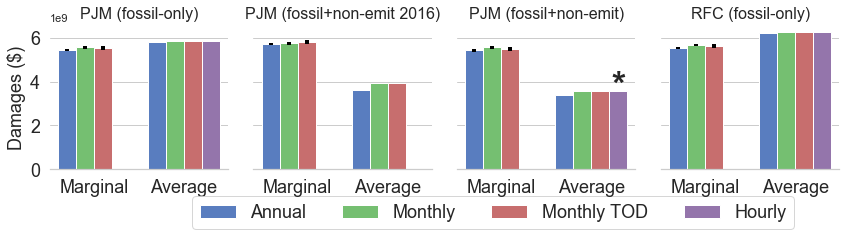

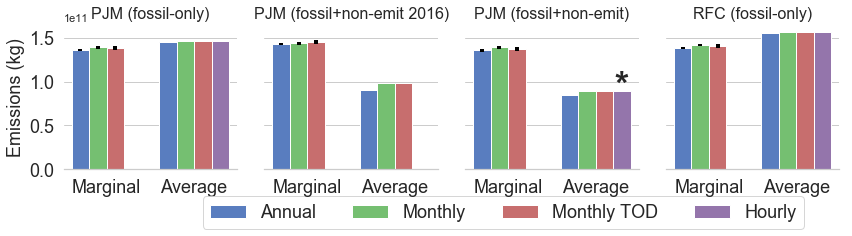

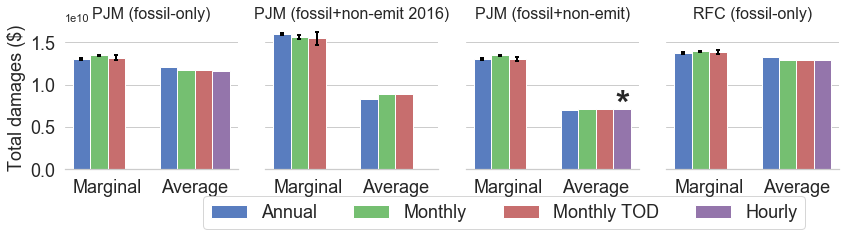

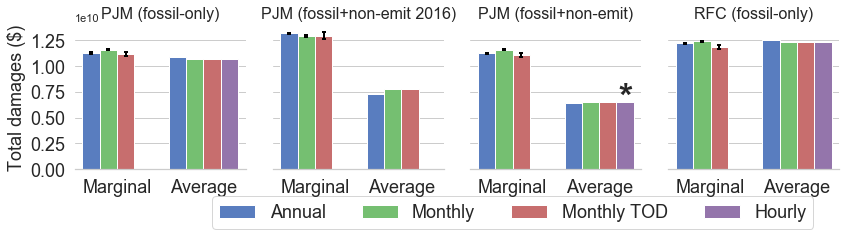

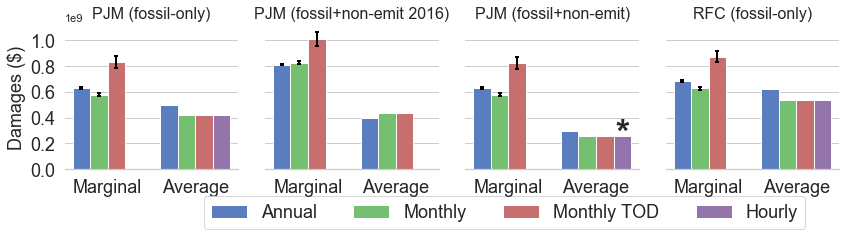

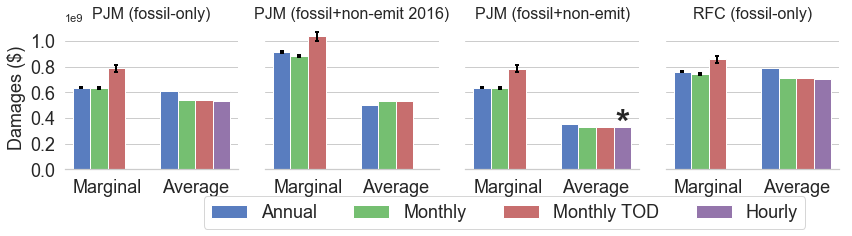

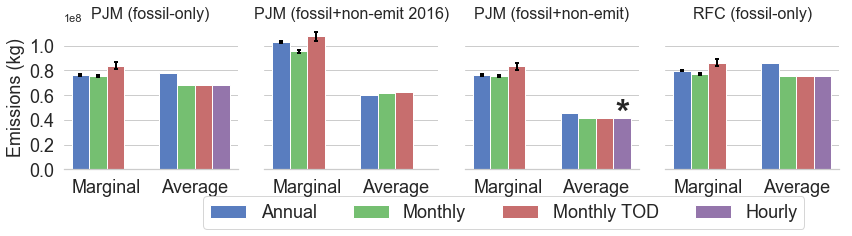

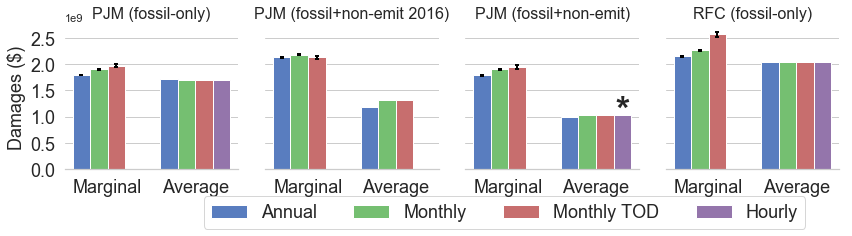

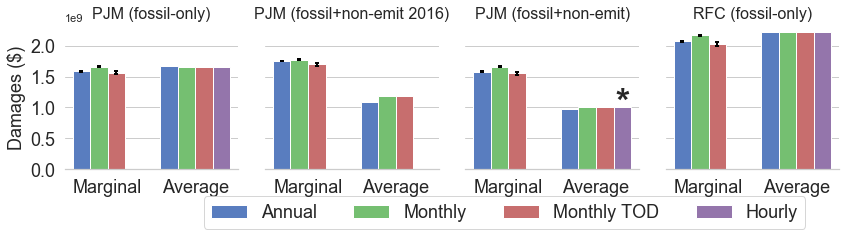

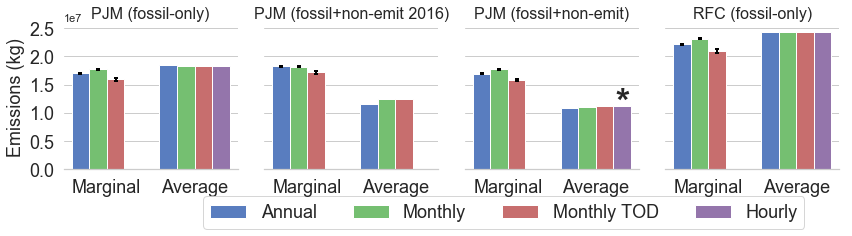

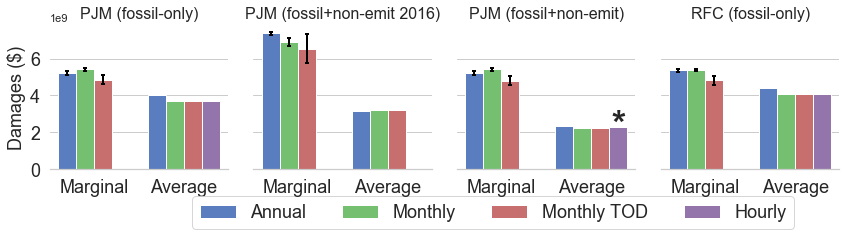

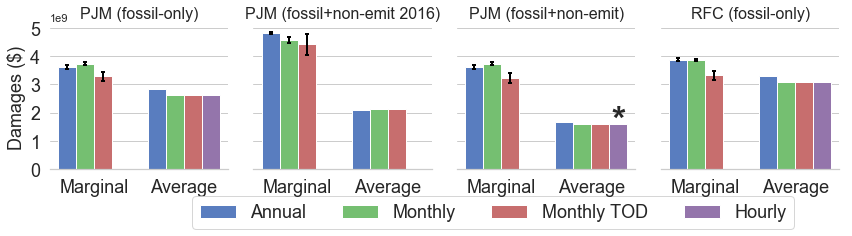

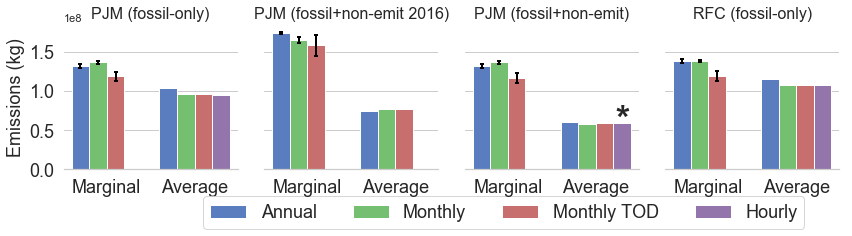

In [27]:
for label in LABELS:
    get_stacked_plot(label)

## Stacked bar plots for total damages 

In [28]:
import matplotlib.patches as mpatches

In [29]:
def plot_total_damages(dam_type, title=False):
    
    fontsize=18
    
    plt.rcParams['hatch.linewidth'] = 0.5
    sns.set(style="whitegrid", color_codes=True)

    dam_cols = dam_cols_eas if dam_type == 'EASIUR' else dam_cols_ap2
    se_col = 'dam_{}-se'.format('eas' if dam_type == 'EASIUR' else 'ap2')

    df = get_onelabel_formatted(dam_cols)
    df = (df.set_index(['spat', 'kind', 'time'])/1e9).reset_index()  # billions
    
    df_cum = df.set_index(['spat', 'kind', 'time']).cumsum(axis=1).reset_index()

    # Stacked bar plot
    g = sns.FacetGrid(data=df_cum, col='spat', size=3, aspect=1)
    hatches = ['||', '///', '', '\\\\\\']

    g.map(sns.barplot, 'kind', dam_cols[-1], 'time', 
          hue_order=['Annual', 'Monthly', 'Monthly TOD', 'Hourly'], order=['Marginal', 'Average'],
          palette=[sns.color_palette('muted')[x] for x in [0,2,3,4]], edgecolor='black', hatch=hatches[0])  
    g.map(sns.barplot, 'kind', dam_cols[-2], 'time', 
          hue_order=['Annual', 'Monthly', 'Monthly TOD', 'Hourly'], order=['Marginal', 'Average'],
          palette=[sns.color_palette('muted')[x] for x in [0,2,3,4]], edgecolor='black', hatch=hatches[1])
    g.map(sns.barplot, 'kind', dam_cols[-3], 'time', 
          hue_order=['Annual', 'Monthly', 'Monthly TOD', 'Hourly'], order=['Marginal', 'Average'],
          palette=[sns.color_palette('muted')[x] for x in [0,2,3,4]], edgecolor='black', hatch=hatches[2])
    g.map(sns.barplot, 'kind', dam_cols[-4], 'time', 
          hue_order=['Annual', 'Monthly', 'Monthly TOD', 'Hourly'], order=['Marginal', 'Average'],
          palette=[sns.color_palette('muted')[x] for x in [0,2,3,4]], edgecolor='black', hatch=hatches[3]).set_titles('{col_name}')
    g.despine(left='true')

    # Legend, fontsize, and other formatting
    xoffset=0.035

    for i, ax in enumerate(g.axes.flatten()):

        ax.set_xlabel('') # No x-label

        if i == 0:
            # y label on left plot
            ax.set_ylabel('Total damages\n(\$ billions)'.format(dam_type))

            # pollutants legend
            leg_dict = dict(zip(dam_cols, ['CO$_2$', 'SO$_2$', 'NO$_x$', 'PM$_{{2.5}}$']))
            dam_patches = []
            for dam, hatch in zip(dam_cols, hatches[::-1]):
                patch = mpatches.Patch(facecolor='white', label=leg_dict[dam], edgecolor='black', hatch=hatch)
                dam_patches.append(patch)

            lgd = ax.legend(handles=dam_patches, loc='center left', 
                            bbox_to_anchor=(0.3+xoffset, -0.15), ncol=4, frameon=True, fontsize=fontsize,
                            bbox_transform=plt.gcf().transFigure)
            plt.text(0.16+xoffset, -0.175, 'Pollutants:', transform=plt.gcf().transFigure,
                     fontsize=fontsize, fontweight='bold')
            lgd.get_frame().set_edgecolor('white')


        if i == 1:

            # temporal scope legend (same length as pollutants legend for alignment)
            blank_patch = mpatches.Patch(color='white', label='')
            ann_patch = mpatches.Patch(color=sns.color_palette('muted')[0], label='Annual', edgecolor='black')
            month_patch = mpatches.Patch(color=sns.color_palette('muted')[2], label='Monthly', edgecolor='black')
            tod_patch = mpatches.Patch(color=sns.color_palette('muted')[3], label='Monthly TOD', edgecolor='black')
            hr_patch = mpatches.Patch(color=sns.color_palette('muted')[4], label='Hourly', edgecolor='black')
            time_patches = [ann_patch, month_patch, tod_patch, hr_patch]
            lgd2 = ax.legend(handles=time_patches, loc='center left', 
                            bbox_to_anchor=(0.27+xoffset, -0.025), ncol=4, frameon=True, fontsize=fontsize-1,
                            bbox_transform=plt.gcf().transFigure)
            plt.text(0.09+xoffset, -0.045, 'Temporal scopes:', transform=plt.gcf().transFigure, 
                     fontsize=fontsize, fontweight='bold')
            lgd2.get_frame().set_edgecolor('white')
            
        # Annotate baseline -- PJM fossil-plus average monthly TOD
        if i == 2:
            baseline_x = 1.3
            patch_width = [p.get_width() for p in ax.patches][0]
            baseline_y = max([p.get_height() \
                          for p in ax.patches if abs(p.get_xy()[0]+patch_width/2-baseline_x)<=patch_width/4])
            ax.text(s='*', x=baseline_x, y=1.05 * baseline_y,
                   horizontalalignment='center', verticalalignment='center', 
                    fontsize=fontsize*2, fontweight='bold')

        # Set font size
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
        ax.title.set_fontsize(fontsize-2)


    # Hacky errorbars
    #   Note/TODO: in billions
    df_tot = get_onelabel_formatted(se_col[:-3])
    df_tot_se = get_onelabel_formatted(se_col)
    for i, ax in enumerate(g.axes[0]):
        spat = df_tot['spat'].dtype.categories[i]
        df_tot_slice = df_tot.query('spat == @spat').query('kind == "Marginal"')
        df_tot_se_slice = df_tot_se.query('spat == @spat').query('kind == "Marginal"')
        ax.errorbar([-0.3, -0.1, 0.1], df_tot_slice[se_col[:-3]].values/1e9,
                        yerr=df_tot_se_slice[se_col].values/1e9, ms=20, color='black', 
                        linewidth=0, elinewidth=2, capsize=2, capthick=2)   

    # Line around legend
    fig = plt.gcf()
    leg_line = \
        mpatches.Rectangle(
            (0.073+xoffset, -0.2), 0.875, 0.24, facecolor='none', edgecolor='lightgray', 
            transform=fig.transFigure, figure=fig)
    fig.patches.extend([leg_line])

    extra_artists = (lgd, lgd2)
    if title:
        sup=fig.text(0.5, 0.9, 'Total damages ({})\n'.format(dam_type), 
                         fontsize=fontsize, fontweight='bold', fontstyle='italic',
                        transform=fig.transFigure, ha='center')
        extra_artists = extra_artists + (sup,)

    plt.tight_layout()
    dirname = os.path.join('plots', 'summer_load')
    if not os.path.exists(dirname): os.makedirs(dirname)
    g.fig.savefig(os.path.join(dirname, 
                               '{}-stacked-with-error{}.pdf'.format(dam_type, '-titled' if title else '')),
                 bbox_extra_artists=extra_artists, bbox_inches='tight')

/Users/priyadonti/anaconda2/envs/py35/lib/python3.5/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/priyadonti/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/patches.py:120: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


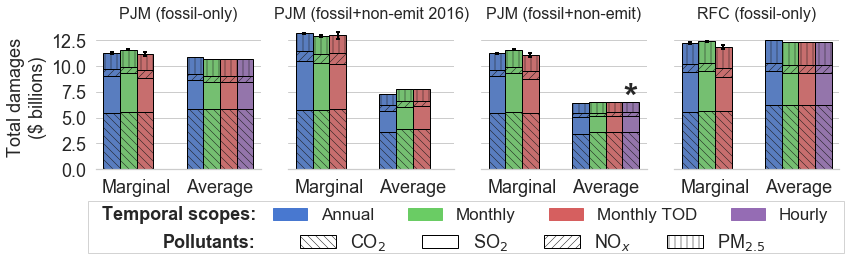

In [30]:
plot_total_damages('EASIUR', title=False)

/Users/priyadonti/anaconda2/envs/py35/lib/python3.5/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/priyadonti/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/patches.py:120: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


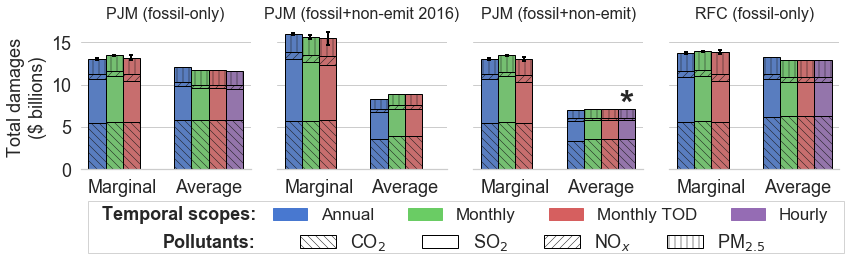

In [31]:
plot_total_damages('AP2', title=False)